# AirBnB Data Analysis: Modelling & Inference

In the current repository, I will analyze the [AirBnB dataset from the Basque Country / Euskadi](http://insideairbnb.com/get-the-data/). The [Basque Country](https://en.wikipedia.org/wiki/Basque_Country_(autonomous_community)) is the region from Spain I am from; after many years living in Germany, I moved back here in 2020. As a popular touristic target on the seaside, the analysis might be valuable for many visitors :-)

The first notebook `00_AirBnB_DataAnalysis_Initial_Tests.ipynb` has defined the main business questions, related to:

1. Most important features for price prediction (= target)
2. Difference in features between the two most important cities: Donostia-San Sebastian & Bilbao
3. Difference in features between cities with beach access and without
4. EXTRA: Predict review score from review texts

Now, the usual data science process continues:

1. Data cleaning and Preparation
2. Exploratory Data Analysis
3. Feature Engineering
4. Feature Selection
5. **Modelling**
6. **Model Scoring & Inferences**
7. Answering and presenting the Business Questions

The previous notebook `02_AirBnB_DataAnalysis_DataCleaning_EDA.ipynb` has performed the Feature Engineering and Selection.

This notebook focuses on the next two steps: **Modelling** and **Model Scoring & Inference**. The processed train/test splits are loaded here, together with additional files (e.g., scaler, mappings, selected features, etc.).

### Overview of Contents in the Current Notebook

1. Load Dataset & Additional Files
2. Model: Linear Regression
	- 2.1 Training and Evaluation
		- Select Features
		- Fit Model
		- Inference
		- Evaluate
		- Scatterplot: True vs. Predicted
		- Error Histogram
	- 2.2 Feature Importance
3. Model: Random Forests
	- 3.1 Training and Evaluation
		- Select Features and Fit Model
		- Inference
		- Evaluation
		- Scatterplot: True vs. Predicted
		- Error Histogram
	- 3.2 Feature Importance
	- 3.3 Computation of Bargains
4. Comparing Listings Depending on Key Values
	- 4.1 Auxiliary Hypothesis Testing Functions
	- 4.2 Apply Hypothesis Testing Depending on Key Feature `has_beach`
	- 4.3 Apply Hypothesis Testing Depending on Key Features: Two Major Cities

In [652]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# To save the model
import joblib

# Display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

## 1. Load Dataset & Additional Files

In [678]:
filepath = './data/euskadi_2022_03_31/'

y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

In [679]:
scaler = joblib.load(filepath+'minmax_scaler.joblib', mmap_mode='r')

In [680]:
property_types = joblib.load(filepath+'property_types.joblib', mmap_mode='r')

In [681]:
selected_features = joblib.load(filepath+'selected_features.joblib', mmap_mode='r')

In [682]:
linear_features = joblib.load(filepath+'linear_features.joblib', mmap_mode='r')

In [683]:
numerical_transform_params = joblib.load(filepath+'numerical_transform_params.joblib', mmap_mode='r')

## 2. Model: Linear Regression

### 2.1 Training and Evaluation

#### Select Features

In [684]:
features = linear_features # all linear/binary
#features = list(X_train.columns) # linear/binary + polynomial
#features = selected_features # reduced set of linear/binary + polynomial

In [685]:
X_train = X_train[features]
X_test = X_test[features]

In [686]:
X_train.shape

(3537, 353)

In [687]:
X_train.max(axis=0)

bedrooms                              1.0
beds                                  1.0
minimum_nights_avg_ntm                1.0
maximum_nights_avg_ntm                1.0
reviews_per_month                     1.0
                                     ... 
amenity_ev_charger                    1.0
amenity_private_patio_or_balcony      1.0
amenity_shared_sauna                  1.0
amenity_dining_table                  1.0
amenity_extra_pillows_and_blankets    1.0
Length: 353, dtype: float64

#### Fit Model

In [688]:
# We apply cross validation to choose the optimum alpha = regularization strength
#alphas = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
alphas = [0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
#lm = LinearRegression()
lm = RidgeCV(alphas=alphas, cv=5)
#lm = LassoCV(alphas=alphas, cv=5, max_iter=5e5, random_state=0)

# Train
lm.fit(X_train, y_train)

RidgeCV(alphas=array([3.e-05, 1.e-04, 3.e-04, 1.e-03, 3.e-03, 1.e-02, 3.e-02, 1.e-01,
       3.e-01, 1.e+00, 3.e+00, 1.e+01, 3.e+01]),
        cv=5)

In [689]:
# Best alpha = regularization strength
lm.alpha_

3.0

In [598]:
#lm.coef_[0]

In [690]:
# Number of non-zero coefficients
#sum(lm.coef_ > 0.0)
sum(abs(lm.coef_[0]) > 0.0)

352

In [691]:
# Total sum of coefficients values
#sum(abs(lm.coef_))
sum(abs(lm.coef_[0]))

29.393258525211447

#### Inference

In [692]:
# Lasso: Predictions
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

#### Evaluate

In [693]:
# Train: RMSE, R2
print('Train RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train), squared=False))))
print('Train R2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred_train))))

print('Test RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred_test))))
print()

r2_test_lm = np.round(r2_score(np.exp(y_test), np.exp(pred_test)),2)

print('Median listing price: ', int(np.exp(y_train).median()))

Train RMSE: 60
Train R2: 0.6313080533619568
Test RMSE: 58
test r2: 0.6229229104047234

Median listing price:  100


#### Scatterplot: True vs. Predicted

In [694]:
np.exp(y_train).quantile(0.85)

price    200.0
Name: 0.85, dtype: float64

(-35.69999999999999, 749.6999999999998, -37.73455763407309, 792.4257103155348)

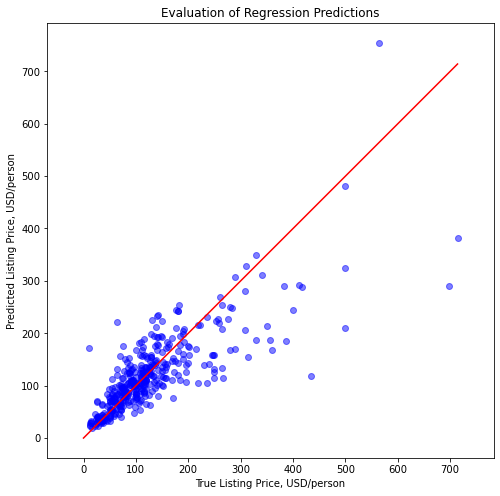

In [695]:
# Real vs. Predicted
# The R2 is only 0.35
# We can see that as the price increases, the prediction error increases
# For large prices the model underpredicts the price.
# That is to be expected, since most of the listings have smaller prices/person
plt.figure(figsize=(8,8))
x = np.exp(y_test)
y_lm = np.exp(lm.predict(X_test))
#x = np.exp(y_train)
#y_lm = np.exp(lm.predict(X_train))
plt.scatter(x, y_lm,color='b',alpha=0.5)
plt.plot(np.array([0,np.max(x)],dtype='object'),np.array([0,np.max(x)],dtype='object'),'r-')
plt.xlabel('True Listing Price, USD/person')
plt.ylabel('Predicted Listing Price, USD/person')
plt.title('Evaluation of Regression Predictions')
plt.axis('equal')

#### Error Histogram

The errors are clearly not normally disturbuted. There are large deviations for low and, specially, for large price values.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

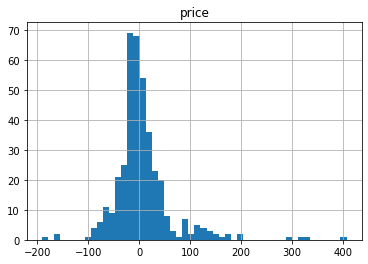

In [696]:
y_lm = pd.DataFrame(y_lm)
y_lm.columns = ['price']
error = x - y_lm
error.hist(bins=50,figsize=(6,4))

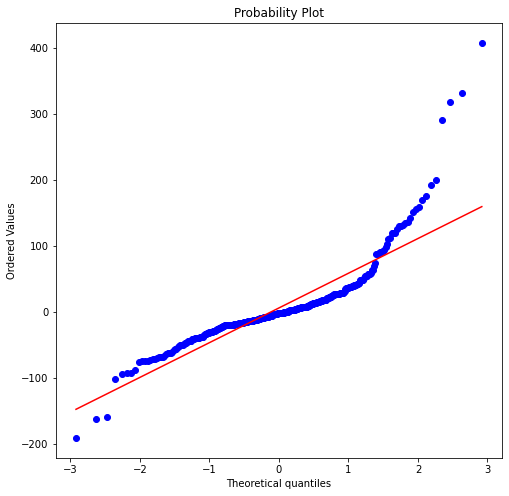

In [697]:
plt.figure(figsize=(8,8))
stats.probplot(error['price'], dist="norm", plot=plt);

### 2.2 Feature Importance

In [698]:
def decode_property_type(df):
    '''This function decodes the property type.'''
    features = list(df.index)
    for i,f in enumerate(features):
        ff = f.split(' ')
        for j, f_ in enumerate(ff):
            if 'property_type' in f_:
                ind = int((f_.split('^')[0]).split('_')[2])-1
                name = property_types['index2name'][ind]
                new_name = '_'.join(name.split(' ')).lower()
                features[i] = features[i].replace(str(ind+1),new_name)
                #print(features[i])
    df.index = features
    return df

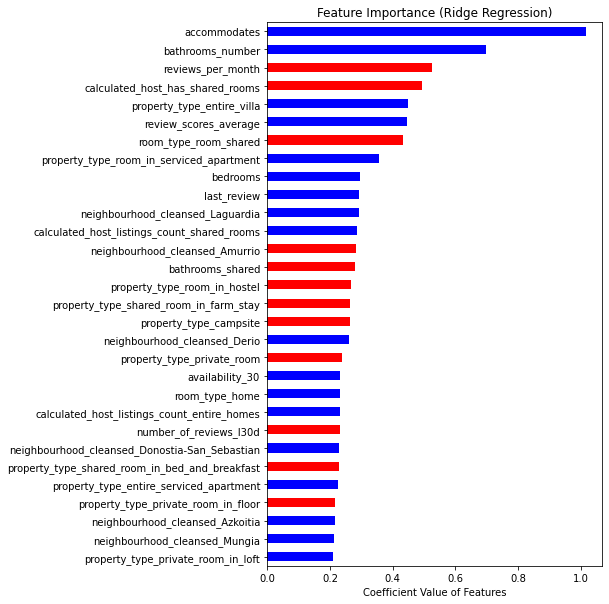

In [699]:
# Construct a data frame with the coefficients
importance = pd.DataFrame(lm.coef_.ravel())
#importance.index = selected_features
importance.index = features
importance.columns = ['coef']
importance['plus'] = importance['coef'].apply(lambda col: 1 if col > 0 else 0)
importance['coef'] = np.abs(importance['coef'])
# Plot top k coefficients
top_features = 30
plt.figure(figsize=(6,10))
importance.sort_values(by='coef',ascending=True,inplace=True)
importance = decode_property_type(importance)
color_list = ['b' if el > 0 else 'r' for el in [importance['plus'].iloc[i] for i in range(importance['plus'].shape[0])]]
importance['coef'][-top_features:].plot(kind='barh',color=color_list[-top_features:])
plt.xlabel('Coefficient Value of Features')
plt.title('Feature Importance (Ridge Regression)')
plt.savefig('./pics/regression_feature_importance_lm.png',dpi=300,transparent=False,bbox_inches='tight')

In [700]:
#pd.DataFrame(importance,columns=['importance']).T
importance.T

,amenity_shared_refrigerator,neighbourhood_cleansed_Plentzia,amenity_fenced_garden_or_backyard,neighbourhood_cleansed_Busturia,amenity_crib,amenity_paid_parking_lot_off_premises,neighbourhood_cleansed_Gautegiz Arteaga,amenity_private_patio_or_balcony,amenity_high_chair,amenity_dedicated_workspace,amenity_fire_extinguisher,description_language_en,minimum_maximum_nights,neighbourhood_cleansed_Barakaldo,availability_365,property_type_entire_loft,amenity_laundromat_nearby,neighbourhood_cleansed_Hernani,amenity_dresser,amenity_barbecue_utensils,amenity_dining_table,bathrooms_private,amenity_free_parking_on_premises,amenity_building_staff,amenity_shared_outdoor_lap_pool,neighbourhood_cleansed_Labastida,amenity_wardrobe,amenity_stainless_steel_electric_stove,amenity_fireplace_guards,amenity_free_driveway_parking_on_premises,amenity_gym,amenity_portable_fans,amenity_dryer,amenity_full_kitchen,amenity_refrigerator,amenity_free_dryer,neighbourhood_cleansed_Azpeitia,amenity_amazon_prime_video,amenity_netflix,amenity_private_pool,host_response_time_few_hours,amenity_window_guards,neighbourhood_cleansed_Mutriku,amenity_board_games,neighbourhood_cleansed_Markina-Xemein,amenity_smoke_alarm,amenity_outlet_covers,property_type_entire_home,amenity_paid_parking_on_premises,amenity_shower_gel,amenity_game_console,amenity_baby_bath,amenity_baking_sheet,description_language_es,amenity_oven,amenity_books_and_toys,amenity_tv,amenity_hot_water_kettle,amenity_waterfront,amenity_pool,longitude,amenity_free_carport_on_premises,amenity_desk,amenity_free_washer,amenity_smart_lock,amenity_cleaning_before_checkout,amenity_extra_pillows_and_blankets,amenity_private_entrance,neighbourhood_group_cleansed_Bizkaia,amenity_stainless_steel_oven,neighbourhood_cleansed_Orio,amenity_body_soap,amenity_shared_hot_tub,neighbourhood_cleansed_Hondarribia,amenity_outdoor_shower,property_type_private_room_in_camper/rv,neighbourhood_cleansed_Vitoria-Gasteiz,amenity_shared_fenced_garden_or_backyard,property_type_private_room_in_serviced_apartment,amenity_lockbox,host_identity_verified,property_type_entire_bungalow,amenity_shared_indoor_heated_olympic-sized_pool,amenity_room-darkening_shades,amenity_table,amenity_shared_pool,amenity_shared_sauna,instant_bookable,amenity_standard_cable,amenity_shampoo,property_type_private_room_in_tiny_home,amenity_cleaning_products,property_type_private_room_in_guest_suite,amenity_ev_charger,beds,property_type_private_room_in_cottage,amenity_beach_essentials,amenity_cable_tv,amenity_trash_compactor,amenity_bed_linens,amenity_coffee_machine,amenity_changing_table,property_type_private_room_in_hostel,amenity_shared_patio_or_balcony,availability_60,property_type_entire_condo,neighbourhood_cleansed_Durango,amenity_first_aid_kit,amenity_patio_or_balcony,amenity_outdoor_infinity_pool,amenity_fast_wifi,amenity_coffee_maker,amenity_shared_indoor_heated_saltwater_pool,amenity_bathtub,amenity_paid_parking_lot_on_premises,calculated_host_listings_count_private_rooms,neighbourhood_cleansed_Elciego,amenity_babysitter_recommendations,property_type_tiny_home,amenity_premium_cable,amenity_host_greets_you,latitude,amenity_heating,amenity_paid_parking_off_premises,amenity_paid_parking_garage_off_premises,amenity_paid_dryer,amenity_lake_access,amenity_luggage_dropoff_allowed,amenity_induction_stove,amenity_single_level_home,amenity_central_heating,amenity_free_parking_garage_on_premises,amenity_monitor,amenity_breakfast,number_of_reviews_ltm,amenity_long_term_stays_allowed,amenity_gas_stove,amenity_office_chair,has_beach,property_type_private_room_in_villa,property_type_entire_rental_unit,maximum_nights,amenity_fire_pit,neighbourhood_cleansed_Aia,availability_90,amenity_central_air_conditioning,amenity_microwave,neighbourhood_cleansed_Deba,amenity_hot_water,neighbourhood_cleansed_Santurtzi,amenity_private_fenced_garden_or_backyard,amenity_sound_system,amenity_paid_washer,amenity_shared_gym_nearby,amenity_bedroom_comforts,amenity_bathroom_essentials,amenity_clothi

In [701]:
property_types['index2name'][21]

'Private room in chalet'

## 3. Model: Random Forests

Since the linear regression model performs so poorly, we try random forests, since often outperform many other models when dealing with tabular data.

### 3.1 Training and Evaluation

#### Select Features and Fit Model

In [702]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Cross-Validation
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

# Parameters for Grid Search
params = {
    'n_estimators': [100, 300, 500]
}

# Select features
#X_train = X_train[selected_features]
#X_test = X_test[selected_features]
X_train = X_train[features]
X_test = X_test[features]

# Create model & fit: Grid Search with Cross Validation
rf = RandomForestRegressor()
grid = GridSearchCV(rf, params, cv=kf)
#rf.fit(X_train, np.ravel(y_train))
grid.fit(X_train, np.ravel(y_train))
rf = grid.best_estimator_
print('Best score: ',grid.best_score_)
print('Best param: ',grid.best_params_)

Best score:  0.732853903911716
Best param:  {'n_estimators': 500}


#### Inference

In [703]:
#Predictions
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

#### Evaluation

In [704]:
# Train: RMSE, R2
print('Train RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train), squared=False))))
print('Train R2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred_train))))

print('Test RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred_test))))
print()

r2_test_rf = np.round(r2_score(np.exp(y_test), np.exp(pred_test)),2)

print('Average listing price: ', int(np.exp(y_train).median()))

Train RMSE: 29
Train R2: 0.9118629782722589
Test RMSE: 53
test r2: 0.6880489990668901

Average listing price:  100


#### Scatterplot: True vs. Predicted

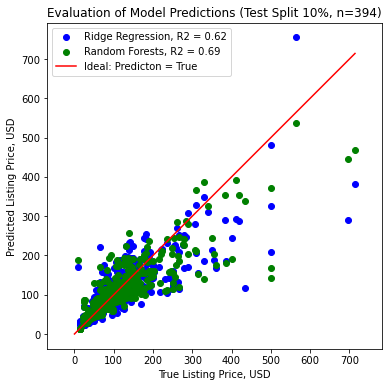

In [705]:
# Real vs. Predicted
# The R2 is only 0.57
# We can see that as the price increases, the prediction error increases
# as heppened with the linear regression model
# However, the prediction and true points are closer to the ideal line
plt.figure(figsize=(6,6))
x = np.exp(y_test)
y_rf = np.exp(rf.predict(X_test))
#x = np.exp(y_train)
#y_rf = np.exp(rf.predict(X_train))
plt.scatter(x, y_lm,color='b',alpha=1.0)
plt.scatter(x, y_rf,color='g',alpha=1.0)
plt.plot(np.array([0,np.max(x)],dtype='object'),np.array([0,np.max(x)],dtype='object'),'r-')
plt.legend([f'Ridge Regression, R2 = {r2_test_lm}',f'Random Forests, R2 = {r2_test_rf}','Ideal: Predicton = True'])
plt.xlabel('True Listing Price, USD')
plt.ylabel('Predicted Listing Price, USD')
plt.title('Evaluation of Model Predictions (Test Split 10%, n=394)')
plt.axis('equal')
plt.savefig('./pics/regression_evaluation.png',dpi=600,transparent=True,bbox_inches='tight')

#### Error Histogram

In [706]:
x.shape, y_rf.shape

((394, 1), (394,))

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

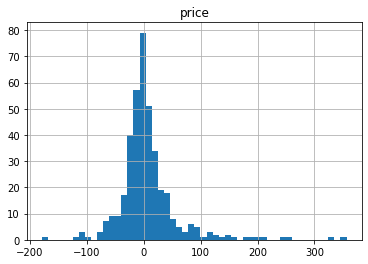

In [707]:
error = x - y_rf.reshape(-1,1)
error.hist(bins=50,figsize=(6,4))

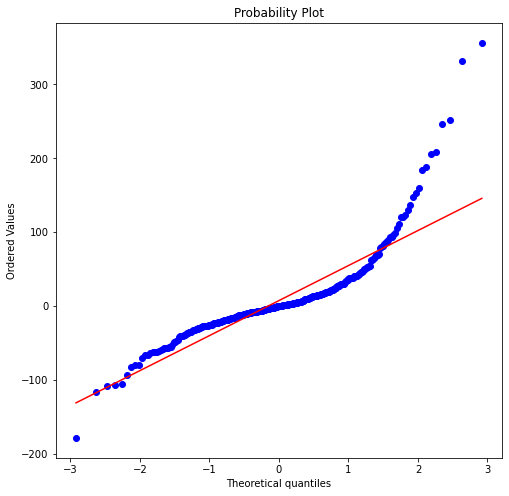

In [708]:
plt.figure(figsize=(8,8))
stats.probplot(error['price'], dist="norm", plot=plt);

### 3.2 Feature Importance

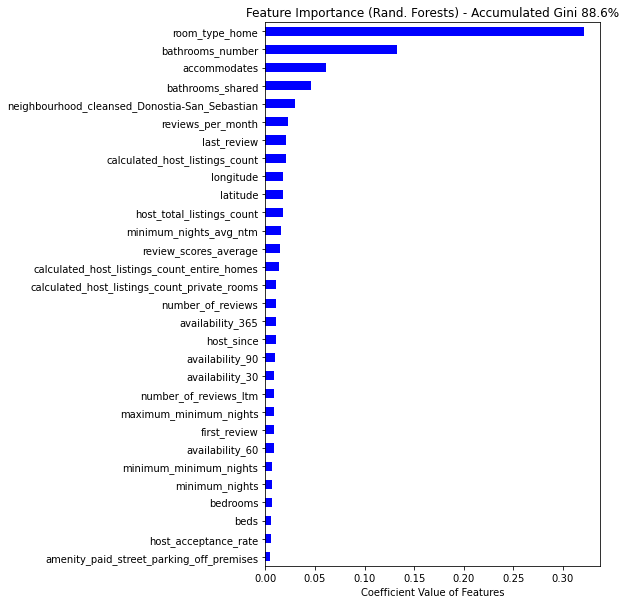

In [709]:
# Construct a data frame with the coefficients
importance = pd.DataFrame(rf.feature_importances_.ravel())
#importance.index = selected_features
importance.index = features
importance.columns = ['coef']
importance['plus'] = importance['coef'].apply(lambda col: 1 if col > 0 else 0)
importance['coef'] = np.abs(importance['coef'])
# Plot top k coefficients
top_features = 30
plt.figure(figsize=(6,10))
importance.sort_values(by='coef',ascending=True,inplace=True)
importance = decode_property_type(importance)
color_list = ['b' if el > 0 else 'r' for el in [importance['plus'].iloc[i] for i in range(importance['plus'].shape[0])]]
importance['coef'][-top_features:].plot(kind='barh',color=color_list[-top_features:])
gini_sum = 0
gini_importances = np.array(importance.iloc[-top_features:]['coef'])
for gini in gini_importances:
    gini_sum += gini
pcnt = np.round(gini_sum*100,2)
plt.xlabel('Coefficient Value of Features')
plt.title(f'Feature Importance (Rand. Forests) - Accumulated Gini {pcnt}%')
plt.savefig('./pics/regression_feature_importance_rf.png',dpi=300,transparent=False,bbox_inches='tight')

In [710]:
importance.T

,amenity_shared_refrigerator,property_type_private_room_in_camper/rv,amenity_shared_outdoor_rooftop_pool,amenity_private_outdoor_infinity_pool,property_type_tiny_home,property_type_shared_room_in_tent,amenity_outdoor_infinity_pool,amenity_private_heated_pool,amenity_private_outdoor_saltwater_pool,property_type_private_room_in_tiny_home,amenity_stainless_steel_electric_stove,property_type_entire_bungalow,amenity_shared_gym_in_building,property_type_shared_room_in_rental_unit,amenity_shared_hot_tub,amenity_free_driveway_parking_on_premises,amenity_shared_outdoor_lap_pool,amenity_shared_indoor_heated_saltwater_pool,amenity_private_gym_nearby,amenity_pool_table,amenity_shared_indoor_heated_olympic-sized_pool,neighbourhood_cleansed_Sestao,amenity_ping_pong_table,amenity_shared_gym_nearby,property_type_shared_room_in_cottage,amenity_apple_tv,neighbourhood_cleansed_Segura,property_type_shared_room_in_farm_stay,neighbourhood_cleansed_Derio,neighbourhood_cleansed_Valdegovia,property_type_farm_stay,amenity_private_sauna,neighbourhood_cleansed_Zuia,amenity_shared_sauna,amenity_coffee_machine,neighbourhood_cleansed_Durango,amenity_free_residential_garage_on_premises,property_type_casa_particular,neighbourhood_cleansed_Leioa,property_type_floor,amenity_portable_air_conditioning,amenity_gas_stove,amenity_gym_nearby,neighbourhood_cleansed_Urduna-Orduna,property_type_private_room_in_floor,neighbourhood_cleansed_Busturia,property_type_private_room_in_guest_suite,property_type_private_room_in_chalet,neighbourhood_cleansed_Sopuerta,property_type_private_room,amenity_central_air_conditioning,neighbourhood_cleansed_Markina-Xemein,amenity_ski-in/ski-out,amenity_private_outdoor_pool,neighbourhood_cleansed_Lasarte-Oria,neighbourhood_cleansed_Plentzia,neighbourhood_cleansed_Urnieta,amenity_shared_fenced_garden_or_backyard,neighbourhood_cleansed_Astigarraga,property_type_room_in_hostel,amenity_self_check-in,amenity_sauna,property_type_private_room_in_loft,property_type_shared_room_in_bed_and_breakfast,property_type_boat,amenity_bread_maker,amenity_private_pool,amenity_private_gym,amenity_lake_access,property_type_private_room_in_serviced_apartment,neighbourhood_cleansed_Eibar,neighbourhood_cleansed_Azkoitia,property_type_private_room_in_townhouse,neighbourhood_cleansed_Errenteria,amenity_baby_safety_gates,amenity_rice_maker,property_type_private_room_in_casa_particular,amenity_private_outdoor_heated_saltwater_pool,property_type_room_in_bed_and_breakfast,neighbourhood_cleansed_Hernani,amenity_chromecast,property_type_room_in_aparthotel,neighbourhood_cleansed_Mendexa,neighbourhood_cleansed_Gorliz,amenity_shared_garden_or_backyard,neighbourhood_cleansed_Ibarrangelu,property_type_private_room_in_cottage,neighbourhood_cleansed_Aia,neighbourhood_cleansed_Laguardia,amenity_premium_cable,amenity_fire_pit,property_type_entire_guesthouse,amenity_boat_slip,amenity_bathroom_essentials,amenity_baby_monitor,neighbourhood_cleansed_Gernika-Lumo,neighbourhood_cleansed_Asteasu,amenity_window_ac_unit,neighbourhood_cleansed_Azpeitia,amenity_bedroom_comforts,amenity_changing_table,neighbourhood_cleansed_Zumaia,amenity_amazon_prime_video,amenity_netflix,neighbourhood_cleansed_Labastida,amenity_private_garden_or_backyard,amenity_walk-in_closet,neighbourhood_cleansed_Mungia,property_type_private_room_in_villa,amenity_office_chair,amenity_pets_allowed,amenity_paid_washer,amenity_ceiling_fan,room_type_room_hotel,neighbourhood_cleansed_Santurtzi,amenity_free_dryer,amenity_trash_compactor,property_type_barn,neighbourhood_cleansed_Ea,property_type_entire_townhouse,amenity_private_fenced_garden_or_backyard,amenity_shared_outdoor_pool,neighbourhood_cleansed_Elciego,property_type_entire_chalet,description_language_fr,amenity_paid_parking_lot_off_premises,neighbourhood_cleansed_Deba,neighbourhood_cleansed_Mundaka,amenity_bikes,neighbourhood_cleansed_Barakaldo,amenity_building_staff,neighbourhood_cleansed_Lekeitio,amenity_full_kitchen,property_type_entire_condo,amenity_free_parking_gar

### 3.3 Computation of Bargains

Bargains are listings which are predicted to have higher prices than the actual ones. Given the low R2 value, the selection of those listings is not that trustworthy, though.

In [711]:
filepath = './data/euskadi_2022_03_31/'

y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

X_all = pd.concat([X_train,X_test],axis=0).reset_index(drop=True)
y_all = pd.concat([y_train,y_test],axis=0).reset_index(drop=True)

X_all.shape, y_all.shape

((3931, 818), (3931, 1))

In [712]:
y = np.exp(y_all).reset_index(drop=True)
y_pred = np.exp(rf.predict(X_all[features]))
y_pred = pd.DataFrame(y_pred,columns=['price']).reset_index(drop=True)

In [713]:
indices = y<y_pred

In [714]:
indices

,price
0,True
1,True
2,False
3,True
4,True
...,...
3926,False
3927,False
3928,True
3929,True


In [715]:
X = X_all.loc[indices.values]
y = y.loc[indices.values]
y_pred = y_pred.loc[indices.values]

In [716]:
threshold_price = y.quantile(0.9)
threshold_score = X['review_scores_average'].quantile(0.9)

In [717]:
indices = X.review_scores_average > threshold_score
indices
X = X[indices.values]
y = y[indices.values]
y_pred = y_pred[indices.values]
X.head()

,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_since,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bedrooms^2,bedrooms beds,bedrooms minimum_nights_avg_ntm,bedrooms maximum_nights_avg_ntm,bedrooms reviews_per_month,bedrooms host_total_listings_count,bedrooms accommodates,bedrooms minimum_nights,bedrooms maximum_nights,bedrooms minimum_minimum_nights,bedrooms maximum_minimum_nights,bedrooms minimum_maximum_nights,bedrooms maximum_maximum_nights,bedrooms number_of_reviews,bedrooms number_of_reviews_ltm,bedrooms calculated_host_listings_count,bedrooms calculated_host_listings_count_entire_homes,bedrooms latitude,bedrooms longitude,bedrooms review_scores_average,bedrooms availability_30,bedrooms availability_60,bedrooms availability_90,bedrooms availability_365,bedrooms number_of_reviews_l30d,bedrooms host_since,bedrooms first_review,bedrooms last_review,bedrooms calculated_host_listings_count_shared_rooms,bedrooms bathrooms_number,beds^2,beds minimum_nights_avg_ntm,beds maximum_nights_avg_ntm,beds reviews_per_month,beds host_total_listings_count,beds accommodates,beds minimum_nights,beds maximum_nights,beds minimum_minimum_nights,beds maximum_minimum_nights,beds minimum_maximum_nights,beds maximum_maximum_nights,beds number_of_reviews,beds number_of_reviews_ltm,beds calculated_host_listings_count,beds calculated_host_listings_count_entire_homes,beds latitude,beds longitude,beds review_scores_average,beds availability_30,beds availability_60,beds availability_90,beds availability_365,beds number_of_reviews_l30d,beds host_since,beds first_review,beds last_review,beds calculated_host_listings_count_shared_rooms,beds bathrooms_number,minimum_nights_avg_ntm^2,minimum_nights_avg_ntm maximum_nights_avg_ntm,minimum_nights_avg_ntm reviews_per_month,minimum_nights_avg_ntm host_total_listings_count,minimum_nights_avg_ntm accommodates,minimum_nights_avg_ntm minimum_nights,minimum_nights_avg_ntm maximum_nights,minimum_nights_avg_ntm minimum_minimum_nights,minimum_nights_avg_ntm maximum_minimum_nights,minimum_nights_avg_ntm minimum_maximum_nights,minimum_nights_avg_ntm maximum_maximum_nights,minimum_nights_avg_ntm number_of_reviews,minimum_nights_avg_ntm number_of_reviews_ltm,minimum_nights_avg_ntm calculated_host_listings_count,minimum_nights_avg_ntm calculated_host_listings_count_entire_homes,minimum_nights_avg_ntm latitude,minimum_nights_avg_ntm longitude,minimum_nights_avg_ntm review_scores_average,minimum_nights_avg_ntm availability_30,minimum_nights_avg_ntm availability_60,minimum_nights_avg_ntm availability_90,minimum_nights_avg_ntm availability_365,minimum_nights_avg_ntm number_of_reviews_l30d,minimum_nights_avg_ntm host_since,minimum_nights_avg_ntm first_review,minimum_nights_avg_ntm last_review,minimum_nights_avg_ntm calculated_host_listings_count_shared_rooms,minimum_nights_avg_ntm bathrooms_number,maximum_nights_avg_ntm^2,maximum_nights_avg_ntm reviews_per_month,maximum_nights_avg_ntm host_total_listings_count,maximum_nights_avg_ntm accommodates,maximum_nights_avg_ntm minimum_nights,maximum_nights_avg_ntm maximum_nights,maximum_nights_avg_ntm minimum_minimum_nights,maximum_nights_avg_ntm maximum_minimum_nights,maximum_nights_avg_ntm minimum_maximum_nights,maximum_nights_avg_ntm maximum_maximum_nights,maximum_nights_avg_ntm number_of_reviews,maximum_nights_avg_ntm number_of_reviews_ltm,maximum_nights_avg_ntm calculated_host_listings_count,maximum_nights_avg_ntm calculated_host_listings_count_entire_homes,maximum_nights_avg_ntm latitude,maximum_nights_avg_ntm l

In [718]:
X.shape, y.shape

((205, 818), (205, 1))

In [721]:
pd.DataFrame(X.columns).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817
0,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,reviews_per_month,host_total_listings_count,accommodates,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,latitude,longitude,review_scores_average,availability_30,availability_60,availability_90,availability_365,number_of_reviews_l30d,host_since,first_review,last_review,calculated_host_listings_count_shared_rooms,bathrooms_number,bedrooms^2,bedrooms beds,bedrooms minimum_nights_avg_ntm,bedrooms maximum_nights_avg_ntm,bedrooms reviews_per_month,bedrooms host_total_listings_count,bedrooms accommodates,bedrooms minimum_nights,bedrooms maximum_nights,bedrooms minimum_minimum_nights,be

In [722]:
data = pd.concat([X,y],axis=1)

In [723]:
#latitude = scaler.inverse_transform(X)[:,18]
#longitude = scaler.inverse_transform(X)[:,19]
latitude_id = 17
longitude_id = 18
latitude = scaler.inverse_transform(X)[:,latitude_id]
longitude = scaler.inverse_transform(X)[:,longitude_id]
data['latitude'] = latitude
data['longitude'] = longitude

In [724]:
data_all = pd.concat([X_all,y_all],axis=1)
latitude = scaler.inverse_transform(X_all)[:,latitude_id]
longitude = scaler.inverse_transform(X_all)[:,longitude_id]
data_all['latitude'] = latitude
data_all['longitude'] = longitude

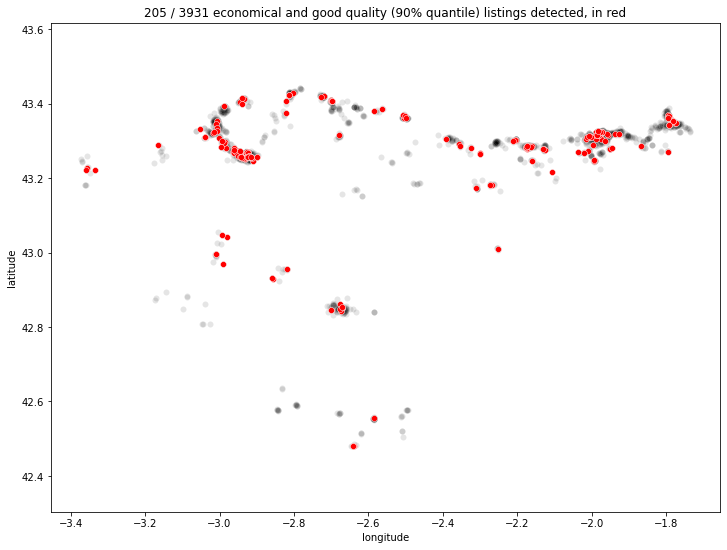

In [725]:
# Property coordinates and their prices enconded with color
# Only properties with access to a beach (< 2km) are considered
#df.plot.scatter(x='longitude',y='latitude',c='price',cmap='coolwarm',figsize=(12,8.5))
plt.figure(figsize=(12,9))
plt.axis('equal')
plt.title(f'{data.shape[0]} / {data_all.shape[0]} economical and good quality (90% quantile) listings detected, in red')
#sns.scatterplot(data=data,x='longitude',y='latitude',hue='price',palette='YlOrBr',alpha=0.3,size='price')
sns.scatterplot(data=data_all,x='longitude',y='latitude',color='black',alpha=0.1)
sns.scatterplot(data=data,x='longitude',y='latitude',color='red')
#plt.legend(loc='lower right',title='Price, USD/person')
plt.savefig('./pics/economical_listings.png',dpi=600,transparent=True,bbox_inches='tight')

## 4. Comparing Listings Depending on Key Values

In [727]:
filepath = './data/euskadi_2022_03_31/'

y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

X_all = pd.concat([X_train,X_test],axis=0).reset_index(drop=True)
y_all = pd.concat([y_train,y_test],axis=0).reset_index(drop=True)

# Reduce complexity by taking only the selected features
X_all = X_all[linear_features]

data = pd.concat([X_all,y_all],axis=1).reset_index(drop=True)

X_all.shape, y_all.shape

((3931, 353), (3931, 1))

In [728]:
# Example: Filter listings from Donostia-San Sebastian and check number of values of a feature
X_all[X_all['neighbourhood_cleansed_Donostia-San_Sebastian'] > 0]['room_type_home'].value_counts()

1.0    986
0.0    306
Name: room_type_home, dtype: int64

In [729]:
# Example: Filter listings from Donostia-San Sebastian and check number of values of a feature
y_all[X_all['has_beach'] > 0].value_counts()

price   
4.605170    81
4.787492    55
4.499810    45
5.010635    42
4.382027    39
            ..
5.746203     1
5.730100     1
3.465736     1
5.720312     1
6.907755     1
Length: 356, dtype: int64

### 4.1 Auxiliary Hypothesis Testing Functions

In [756]:
import scipy.stats.distributions as dist
import scipy.stats as stats

In [757]:
def z_test(subset1, subset2):
    '''This function computes the Z Test of two population proportions.
    H0: The proportions are the same.
    Ha: The proportions are different (two-sided).
    
    Input:
        subset1: data frame with values to analyze for subset/group 1
        subset1: data frame with values to analyze for subset/group 2
    Output:
        z_stat: Z statistic; if very negative, subset1 has a considerebly smaller proportion
        p_value: if < 0.05, the difference is significant, the two proportions are different
    '''
    # Sample sizes
    n1 = subset1.shape[0]
    n2 = subset2.shape[0]
    
    # Number of positive values
    y1 = subset1.sum()
    y2 = subset2.sum()

    # Estimates of the population proportions
    p1 = np.round(y1 / n1, 2)
    p2 = np.round(y2 / n2, 2)
    
    if p1 == p2:
        print('Warning: same proportions!')

    # Estimate of the combined population proportion
    phat = (y1 + y2) / (n1 + n2)

    # Estimate of the variance of the combined population proportion
    va = phat * (1 - phat)

    # Estimate of the standard error of the combined population proportion
    se = np.sqrt(va * ((1.0 / n1) + (1.0 / n2)))

    # Test statistic and its p-value: 2-sided, because the Ha is !=
    z_stat = (p1 - p2) / se
    p_value = 2*dist.norm.cdf(-np.abs(z_stat))
    # Equivalent to
    # p_value = 2*(1-dist.norm.cdf(np.abs(z_stat)))

    return (z_stat, p_value, p1, p2)

In [758]:
# Check function

group1 = 'neighbourhood_cleansed_Donostia-San_Sebastian'
group2 = 'neighbourhood_cleansed_Bilbao'
feature_analyze = 'bathrooms_shared'

subset1 = X_all[X_all[group1] > 0][feature_analyze]
subset2 = X_all[X_all[group2] > 0][feature_analyze]

(z_stat, p_value, p1, p2) = z_test(subset1, subset2)

print(f'Z Statistic: {np.round(z_stat,6)}, P-Value: {np.round(p_value,6)}, p1 = {np.round(p1,2)}, p2 = {np.round(p2,2)}')

Z Statistic: -9.838407, P-Value: 0.0, p1 = 0.11, p2 = 0.27


In [759]:
def t_test(subset1, subset2):
    '''This function computes the Z Test of two population proportions.
    H0: The proportions are the same.
    Ha: The proportions are different (two-sided).

    Input:
        subset1: data frame with values to analyze for subset/group 1
        subset1: data frame with values to analyze for subset/group 2
    Output:
        t_stat: T statistic; if very negative, subset1 has a considerebly smaller mean
        p_value: if < 0.05, the difference is significant, the two distribution means are different
    '''
    
    # Sample sizes    
    n1 = subset1.shape[0]
    n2 = subset2.shape[0]
    
    # Means
    m1 = subset1.mean()
    m2 = subset2.mean()

    # Standard Deviations
    sd1 = subset1.std()
    sd2 = subset2.std()

    # Standard Error
    if sd1/sd2 < 2.0 or sd2/sd1 < 2.0:
        # Similar variances: Pooled
        se = np.sqrt(((sd1**2)/n1) + ((sd2**2)/n2))
    else:
        # Different variances: Unpooled
        se = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2)/(n1+n2-2)) * np.sqrt((1/n1) + (1/n2))
    
    # T statistic
    t_stat = (m1 - m2)/se    
    # With T and df, we can get the p-value from the T distribution
    df = n1 + n2 - 2
    # p-value is obtained form the cummulative density function (CDF) with the given df
    # since we want the remaining are under the PDF, we need to compute 1-CDF(t)
    # Since it is a 2-sided test (Ha !=), we need to x2 the p-value
    p_value = 2*(1 - dist.t.cdf(np.abs(t_stat),df=df))
    
    return (t_stat, p_value, m1, m2)

In [760]:
# Check function

group1 = 'has_beach' # == 1
group2 = 'has_beach' # == 0
feature_analyze = 'review_scores_average'

subset1 = X_all[X_all[group1] > 0][feature_analyze]
subset2 = X_all[X_all[group2] < 1][feature_analyze]

(t_stat, p_value, m1, m2) = t_test(subset1, subset2)

# Watch out: variables must be transformed with the inverse!
print(f'T Statistic: {np.round(t_stat,6)}, P-Value: {np.round(p_value,6)}, m1 = {np.round(m1,2)}, m2 = {np.round(m2,2)}')

group1 = 'has_beach' # == 1
group2 = 'has_beach' # == 0
feature_analyze = 'price'

subset1 = y_all[X_all[group1] > 0][feature_analyze]
subset2 = y_all[X_all[group2] < 1][feature_analyze]

(t_stat, p_value, m1, m2) = t_test(subset1, subset2)

m1 = np.exp(m1)
m2 = np.exp(m2)

print(f'T Statistic: {np.round(t_stat,6)}, P-Value: {np.round(p_value,6)}, m1 = {np.round(m1,2)}, m2 = {np.round(m2,2)}')

T Statistic: 3.20063, P-Value: 0.001382, m1 = 0.95, m2 = 0.94
T Statistic: 16.371204, P-Value: 0.0, m1 = 116.86, m2 = 80.29


### 4.2 Apply Hypothesis Testing Depending on Key Feature `has_beach`

In [761]:
features = list(X_all.columns)
features = features + ['price']

In [762]:
group1 = 'has_beach' # == 1
group2 = 'has_beach' # == 0

features_in_both_groups = []
features_in_one_group = []
feature_stats = {}
feature_ps = {}
for feat in features:
    # Select subsets
    if feat == 'price':
        subset1 = y_all[X_all[group1] > 0][feat]
        subset2 = y_all[X_all[group2] < 1][feat]
        if subset1.sum() > 0 and subset2.sum() > 0:
            # T-Test
            (stat, p_value, m1, m2) = t_test(subset1, subset2)
            # Save values
            features_in_both_groups.append(feat)
            feature_stats[feat] = stat
            feature_ps[feat] = p_value
        else:
            features_in_one_group.append(feat)
    else:
        # rest of features
        subset1 = X_all[X_all[group1] > 0][feat]
        subset2 = X_all[X_all[group2] < 1][feat]

        if subset1.sum() > 0 and subset2.sum() > 0:
            # Decide T-test / Z-test
            if len(subset1.value_counts()) > 2:
                # T-test
                (stat, p_value, m1, m2) = t_test(subset1, subset2)    
            else:
                # Z-test
                (stat, p_value, p1, p2) = z_test(subset1, subset2)
            # Save values
            features_in_both_groups.append(feat)
            feature_stats[feat] = stat
            feature_ps[feat] = p_value
        else:
            features_in_one_group.append(feat)

In [763]:
#features_in_one_group

In [764]:
#feature_stats

In [765]:
# Create data frame with stats
feature_differences = pd.DataFrame.from_dict(feature_stats, orient='index')
feature_differences.columns = ['stat']

In [766]:
# Take only absolute stat value
# but save the stat sign; positive sign means first group has larger aggregate (proportion/mean)
feature_differences['plus'] = feature_differences['stat'].apply(lambda col: 1 if col > 0 else 0)
feature_differences['stat'] = np.abs(feature_differences['stat'])

In [767]:
# Drop longitude and latitude, since they are not relevant for comparisons
feature_differences.drop('longitude',axis=0,inplace=True)
feature_differences.drop('latitude',axis=0,inplace=True)

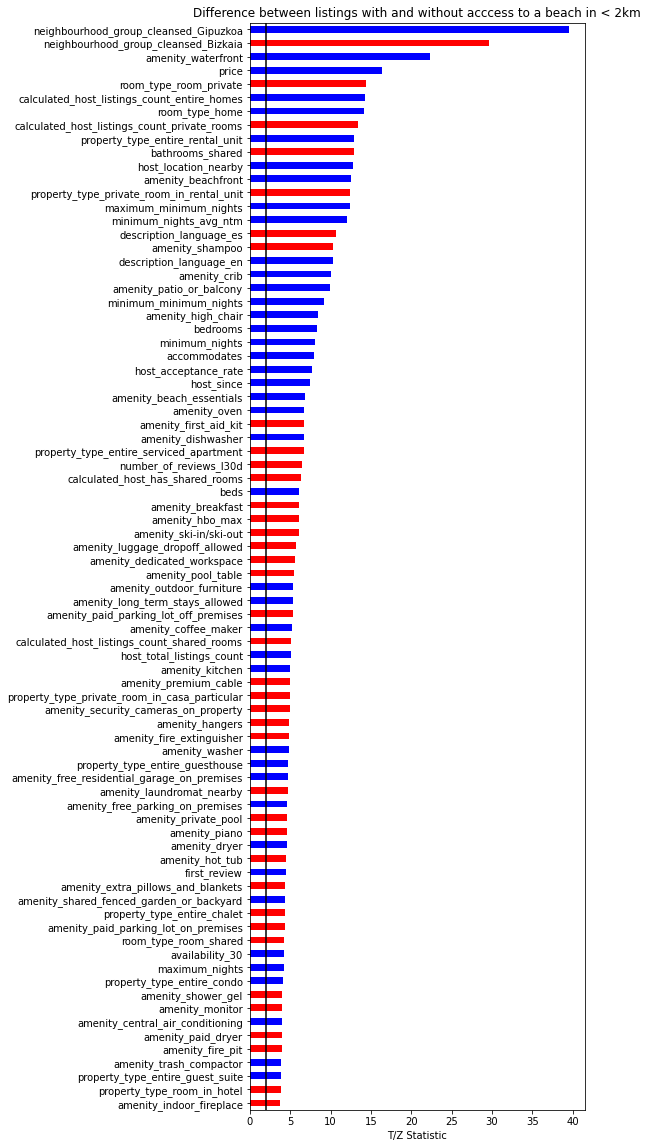

In [768]:
# Pick top k features with largest stats
# Plot their abs stat value; color-code the stat sign
# Draw the stat = 2 line, related to the significance level difference
top_features = 80
plt.figure(figsize=(6,20))
feature_differences.sort_values(by='stat',ascending=True,inplace=True)
feature_differences = decode_property_type(feature_differences)
color_list = ['b' if el > 0 else 'r' for el in [feature_differences['plus'].iloc[i] for i in range(feature_differences['plus'].shape[0])]]
feature_differences['stat'][-top_features:].plot(kind='barh',color=color_list[-top_features:])
plt.plot([2,2],[-1,top_features],'k-')
plt.xlabel('T/Z Statistic')
plt.title('Difference between listings with and without acccess to a beach in < 2km')
plt.savefig('./pics/beach_comparison.png',dpi=200,transparent=False,bbox_inches='tight')

### 4.3 Apply Hypothesis Testing Depending on Key Features: Two Major Cities

In [769]:
features = list(X_all.columns)
features = features + ['price']

In [770]:
group1 = 'neighbourhood_cleansed_Donostia-San_Sebastian' # == 1
group2 = 'neighbourhood_cleansed_Bilbao' # == 1

features_in_both_groups = []
features_in_one_group = []
feature_stats = {}
feature_ps = {}
for feat in features:
    # Select subsets
    if feat == 'price':
        subset1 = y_all[X_all[group1] > 0][feat]
        subset2 = y_all[X_all[group2] > 0][feat]
        if subset1.sum() > 0 and subset2.sum() > 0:
            # T-Test
            (stat, p_value, m1, m2) = t_test(subset1, subset2)
            # Save values
            features_in_both_groups.append(feat)
            feature_stats[feat] = stat
            feature_ps[feat] = p_value
        else:
            features_in_one_group.append(feat)
    else:
        # rest of features
        subset1 = X_all[X_all[group1] > 0][feat]
        subset2 = X_all[X_all[group2] > 0][feat]

        if subset1.sum() > 0 and subset2.sum() > 0:
            # Decide T-test / Z-test
            if len(subset1.value_counts()) > 2:
                # T-test
                (stat, p_value, m1, m2) = t_test(subset1, subset2)    
            else:
                # Z-test
                (stat, p_value, p1, p2) = z_test(subset1, subset2)
            # Save values
            features_in_both_groups.append(feat)
            feature_stats[feat] = stat
            feature_ps[feat] = p_value
        else:
            features_in_one_group.append(feat)

In [771]:
# Create data frame with stats
feature_differences = pd.DataFrame.from_dict(feature_stats, orient='index')
feature_differences.columns = ['stat']

In [772]:
# Take only absolute stat value
# but save the stat sign; positive sign means first group has larger aggregate (proportion/mean)
feature_differences['plus'] = feature_differences['stat'].apply(lambda col: 1 if col > 0 else 0)
feature_differences['stat'] = np.abs(feature_differences['stat'])

In [773]:
# Drop longitude and latitude, since they are not relevant for comparisons
feature_differences.drop('longitude',axis=0,inplace=True)
feature_differences.drop('latitude',axis=0,inplace=True)

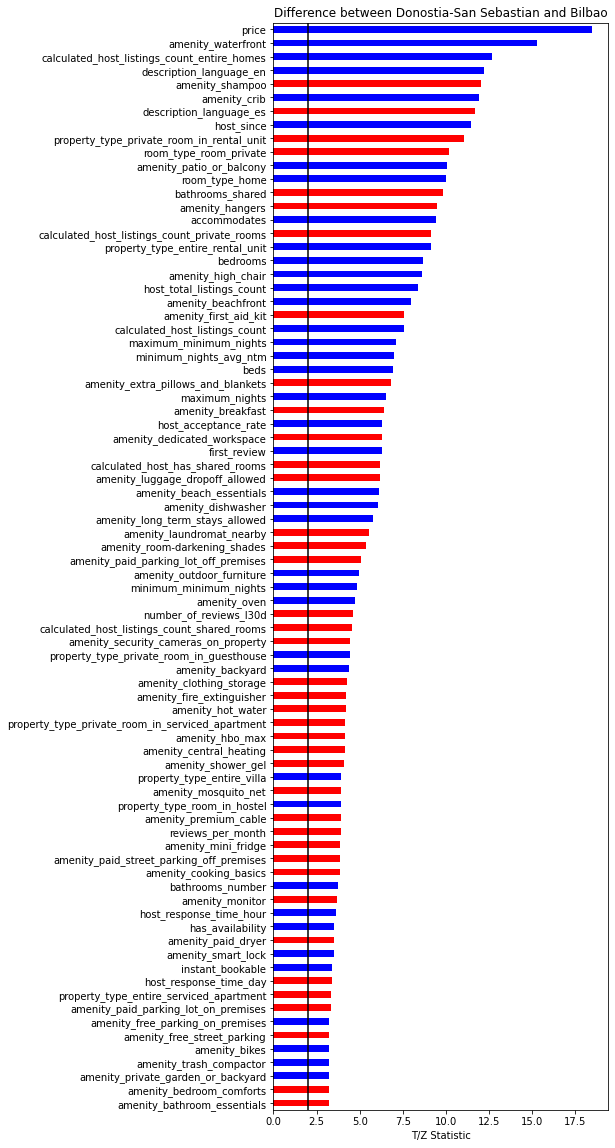

In [774]:
# Pick top k features with largest stats
# Plot their abs stat value; color-code the stat sign
# Draw the stat = 2 line, related to the significance level difference
top_features = 80
plt.figure(figsize=(6,20))
feature_differences.sort_values(by='stat',ascending=True,inplace=True)
feature_differences = decode_property_type(feature_differences)
color_list = ['b' if el > 0 else 'r' for el in [feature_differences['plus'].iloc[i] for i in range(feature_differences['plus'].shape[0])]]
feature_differences['stat'][-top_features:].plot(kind='barh',color=color_list[-top_features:])
plt.plot([2,2],[-1,top_features],'k-')
plt.xlabel('T/Z Statistic')
plt.title('Difference between Donostia-San Sebastian and Bilbao')
plt.savefig('./pics/donostia_bilbao_comparison.png',dpi=200,transparent=False,bbox_inches='tight')